## MNIST

In [1]:
from sklearn.datasets import fetch_openml

#이미지 데이터이므로 df 대신 as_frame=False로 통해 넘파이 배열로 반환
mnist=fetch_openml('mnist_784',as_frame=False) 

/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
X,y=mnist.data, mnist.target

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

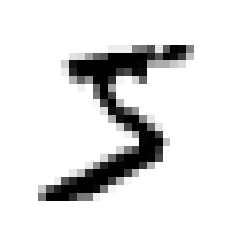

In [3]:
#이미지를 확인하는 방법
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image=image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
some_digit=X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [4]:
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## 이진 분류기 훈련

In [5]:
y_train_5=(y_train=='5')
y_test_5=(y_test=='5')

In [6]:
#SGD

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit])

array([ True])

## 교차 검증을 사용한 정확도 측정

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#모든 이미지를 가장 많이 등장하는 클래스(음성 클래스, '5가 아님')로 분류하는 더미 분류기 생성
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train))) #False: true로 예측된 것이 없음

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## 오차 행렬을 사용한 정확도 측정

In [8]:
#실제 타깃과 비교할 수 있도록 예측값을 만들기(테스트 세트를 사용하지 않고)
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [9]:
#실제 오차 행렬 만들기
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_train_5, y_train_pred)

In [19]:
cm

#첫번째 행: '5 아님' 이미지(음성 클래스, negative class)에 대한 진짜 음성(true negative)와 거짓 양성(false negative),1종 오류(type 1 error)
#두번째 행: '5' 이미지(양성 클래스, positive class)에 대한 거짓 음성(false negative),2종 오류(type 2 error)와 진짜 양성(true positive) 

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
#완벽한 분류기일 경우
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

In [37]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [93]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

## 정밀도/재현율 트레이드오프

In [26]:
#각 샘플의 점수를 얻기
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [16]:
threshold=0 #무조건 True를 반환
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [17]:
threshold=3000 #임곗값을 높일수록 재현율이 줄어듦
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False, False, False, ...,  True, False, False])

적절한 임곗값을 정하기

In [27]:
#훈련 세트에 있는 모든 샘플의 점수 구하기
from sklearn.model_selection import cross_val_predict

y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                          method="decision_function")

1

In [28]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [47]:
#함수를 이용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

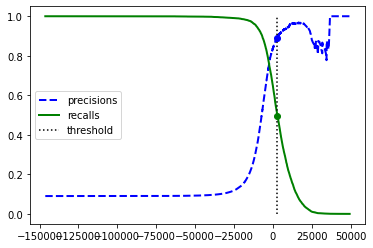

In [71]:
#임곗값의 함수로 정밀도와 재현율 그리기
idx_for_threshold=(thresholds>=threshold).argmax()

plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.plot([threshold],[precisions[idx_for_threshold]],"bo")
plt.plot([threshold],[recalls[idx_for_threshold]],"go")
plt.legend()

plt.show()

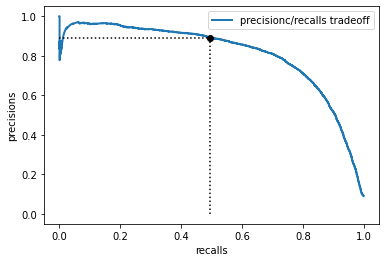

In [73]:
#재현율에 대한 정밀도 곡선 그리기
plt.plot(recalls, precisions, linewidth=2, label="precisionc/recalls tradeoff")
plt.plot(recalls[idx_for_threshold],precisions[idx_for_threshold],"ko")
plt.vlines(recalls[idx_for_threshold],0,precisions[idx_for_threshold],"k","dotted")
plt.hlines(precisions[idx_for_threshold],0,recalls[idx_for_threshold],"k","dotted")
plt.xlabel("recalls")
plt.ylabel("precisions")
plt.legend()

plt.show()

In [32]:
#정밀도가 최소 90%가 되는 가장 낮은 임곗값을 선택하는 방법
idx_for_90_precision=(precisions>=0.90).argmax()
threshold_for_90_precision=thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439594

In [35]:
#훈련 세트에 대한 예측 만들기
y_train_pred_90=(y_scores>=threshold_for_90_precision)

In [38]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [39]:
recall_at_90_precision=recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC 곡선

In [76]:
##임곗값에서 TPR과 FPR 계산하기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

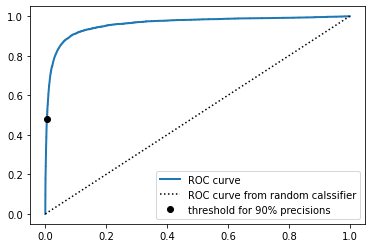

In [77]:
idx_for_threshold_at_90=(thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90=tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1],[0,1],'k:',label="ROC curve from random calssifier")
plt.plot([fpr_90],[tpr_90],"ko",label="threshold for 90% precisions")
plt.legend()

plt.show()

In [78]:
#ROC의 ACU 계산하기
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [80]:
#RandomForestClassifier를 통해 SGDClassifier의 PR 곡선과 F1 점수를 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)

#precision_recall_curve 함수를 사용하기 위해선 각 샘플의 점수가 필요
#RandomForestClassifier가 제공하는 predict_proba 메서드를 사용해 양성 클래스에 대한 확률을 점수로 사용
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [81]:
#1열에는 음성이라고 예측할 확률, 2행에는 양성이라고 예측할 확률이 담겨 있음
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [87]:
#양성 클래스에 대한 추정 확률을 사용
y_scores_forest=y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest=precision_recall_curve(
    y_train_5, y_scores_forest)

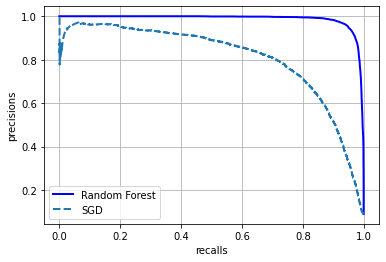

In [91]:
plt.plot(recalls_forest,precisions_forest,"b-",linewidth=2,label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("recalls")
plt.ylabel("precisions")
plt.legend()
plt.grid()

plt.show()
#램덤 포레스트 분류기가 그래프의 모서리에 더 가까워(AUC가 높아) SGD 분류기보다 더 좋음

In [94]:
#F1 점수와 AUC 비교
y_train_pred_forest=y_probas_forest[:,1]>=0.5
f1_score(y_train_5,y_train_pred_forest)

0.9274509803921569

In [96]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## OvR과 OvO

In [97]:
from sklearn.svm import SVC

svm_clf=SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])
#사이킷런이 알아서 OvO 전략을 사용해 이진 분류기를 훈련

SVC(random_state=42)

In [98]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [99]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

#각 클래스마다 한개씩 총 10개의 점수를 반환
#각 클래스는 동률 문제를 해결하기 위해 분류기 점수를 기반으로 각 쌍에서 이긴 횟수에 약간의 조정 값을 더하거나 뺌

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [101]:
class_id=some_digit_scores.argmax()
class_id

5

In [103]:
#classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬해 저장
svm_clf.classes_

#클래스 확인하기
svm_clf.classes_[class_id]

'5'

In [104]:
#OvR이나 OvO의 사용을 강제하기
from sklearn.multiclass import OneVsRestClassifier

ovr_clf=OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [105]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [107]:
#분류기의 개수 확인하기
len(ovr_clf.estimators_)

10

In [109]:
#다중 분류 데이터셋에서 SGDClassifier를 훈련하고 예측을 만들기
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [110]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [112]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [114]:
#입력의 스케일을 조정해 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 오류 분석

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
#오차 행렬을 컬러 그래프로 나타내기
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                       normalize="true", values_format=".0%")

In [ ]:
sample_weight=(y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                       sample_weight=sample_weight,
                                       normalize="true", values_format=".0%")

In [ ]:
#3과 5의 샘플 그리기
cl_a, cl_b='3','5'

X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]